# Notebook Purpose
Now that we have our data set matched up we can do some exploratory analysis to see what we are working with:

## Load Libraries and Data

In [362]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [363]:
reviews = pd.read_parquet('data/matches.parquet')

/opt/tljh/user/lib/python3.6/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/opt/tljh/user/lib/python3.6/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/opt/tljh/user/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


## Convenience Functions for Plots
Since we'll always want things like titles, these help keep our code concise later on with sensible defaults.

In [364]:
def showplot(data, plot, title, xlab, ylab, kde=False, color=None, figsize='wide',
             xmax = None, bins = None, x=None, y=None, fontscale = 1):
    
    # some nice preset sizes
    figsizes = {
        'small':(10,6),
        'wide':(18,6),
        'large':(18,12)
    }
    # pick the preset size
    sns.set(rc={'figure.figsize':figsizes.get(figsize)})
    
    # pick the chosen type
    if plot == 'dist':
        myplot = sns.distplot(data, kde=kde, color=color, bins=bins),
    elif plot == 'bar':
        myplot = sns.barplot( x=x, y=y, data=data, color=color)
    else:
        raise ('Provide a plot type!')

    # add labels
    plt.title(title, fontsize=18)
    plt.xlabel(xlab, fontsize=16)
    plt.ylabel(ylab, fontsize=16)
    sns.set(font_scale=fontscale)
    
    # change xscale if needed
    if xmax is not None:
        plt.xlim(0,xmax)
    
    # save to disk so we can display in readme
    plt.savefig('images/'+title)

## Clean Whisky Styles

LCBO subcategorynames are missing a lot of data so we can go by Reddit styles after a quick cleanup:

In [365]:
def clean_styles(style):
    reg_bourbon = "bourbon|bouron|Borubon"
    reg_islay = "islay"
    # Islands like to have their own style so they mention it a lot
    reg_island = "Islands|Island \(Skye\)|Isle of Skye|Isle of Arran|Island \(Orkney\)|Skye"
    reg_highland = "West Highland Single Malt|Highlands|highland"
    reg_irish = "Irish Blend"
    reg_blend = "Blended malt|Blend|blend"
    reg_canada = "canada"
    # Nobody can spell Campbeltown
    reg_campbeltown = "Cambletown|Cambeltown|Campeltown"
    reg_india = "Indian Single Malt"
    style = style.strip()
    style = re.sub(reg_bourbon, 'Bourbon', style)
    style = re.sub(reg_islay, 'Islay', style)
    style = re.sub(reg_island, 'Island', style)
    style = re.sub(reg_highland, 'Highland', style)
    style = re.sub(reg_blend, 'Blend', style)
    style = re.sub(reg_irish, 'Irish', style)
    style = re.sub(reg_canada, 'Canada', style)
    style = re.sub(reg_campbeltown, 'Campbeltown', style)
    style = re.sub(reg_india, 'India', style)
    return style

In [366]:
reviews['style'] = reviews.apply(lambda row: clean_styles(row['style']), axis='columns')

Save to parquet to be used in sprint 2:

In [378]:
reviews.to_parquet('../sprint_2/data/matches_cleanstyles.parquet')

## Reviews per Whisky

### Overall

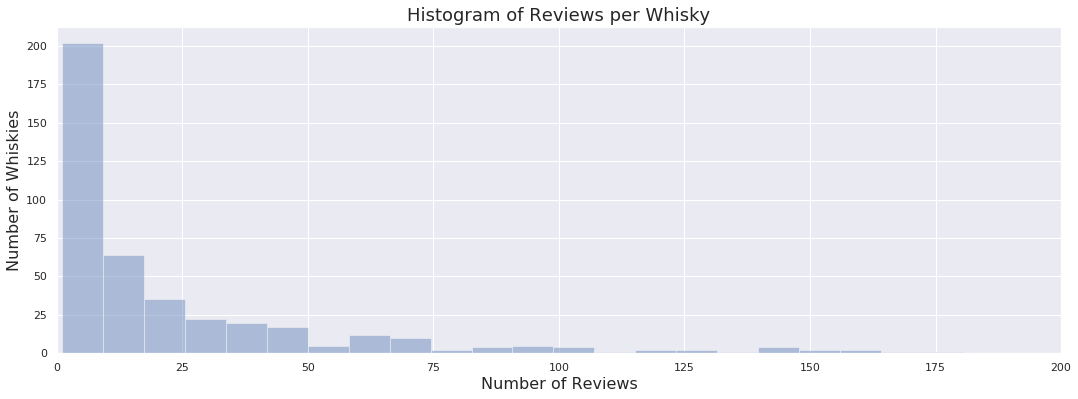

In [367]:
reviewbywhisky = reviews.groupby('Name')['reviewID'].count()
showplot(reviewbywhisky, 'dist', 'Histogram of Reviews per Whisky', 'Number of Reviews', 'Number of Whiskies', xmax=200)

Most whiskies don't have a lot of reviews, but there are a few with really high counts! Let's look at the top 10:

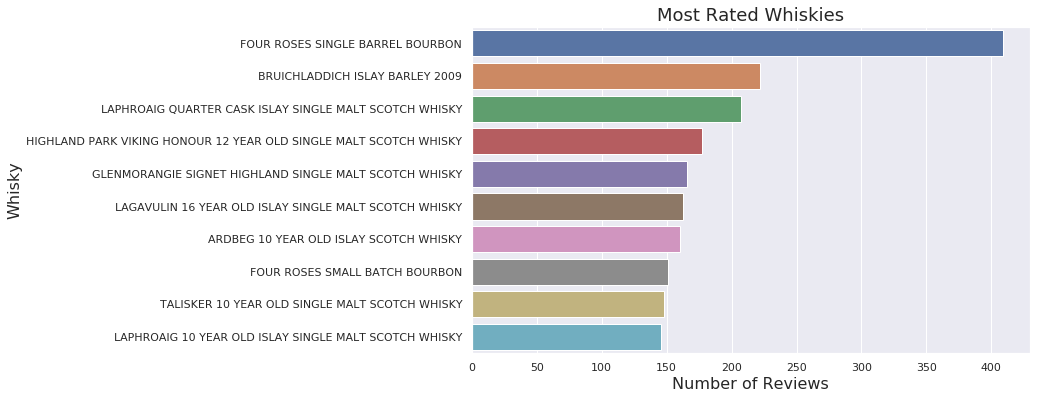

In [368]:
topreviewed = (pd.DataFrame(reviewbywhisky)
                   .rename({'reviewID':'reviewCount'}, axis='columns')
                   .sort_values(by='reviewCount',ascending=False)
                   .head(10)
                   .reset_index()
                   .rename({'index':'Name'})
              )

showplot(topreviewed, 'bar', 'Most Rated Whiskies', 'Number of Reviews', 'Whisky', y="Name", x='reviewCount', figsize='small')

Wow, Four Roses is really popular! Most of the others are pretty standard well known whiskies, but a few stand out to me. I would have expected Laphroaig 10 to be more popular than the Quarter Cask, for example.

### By Style

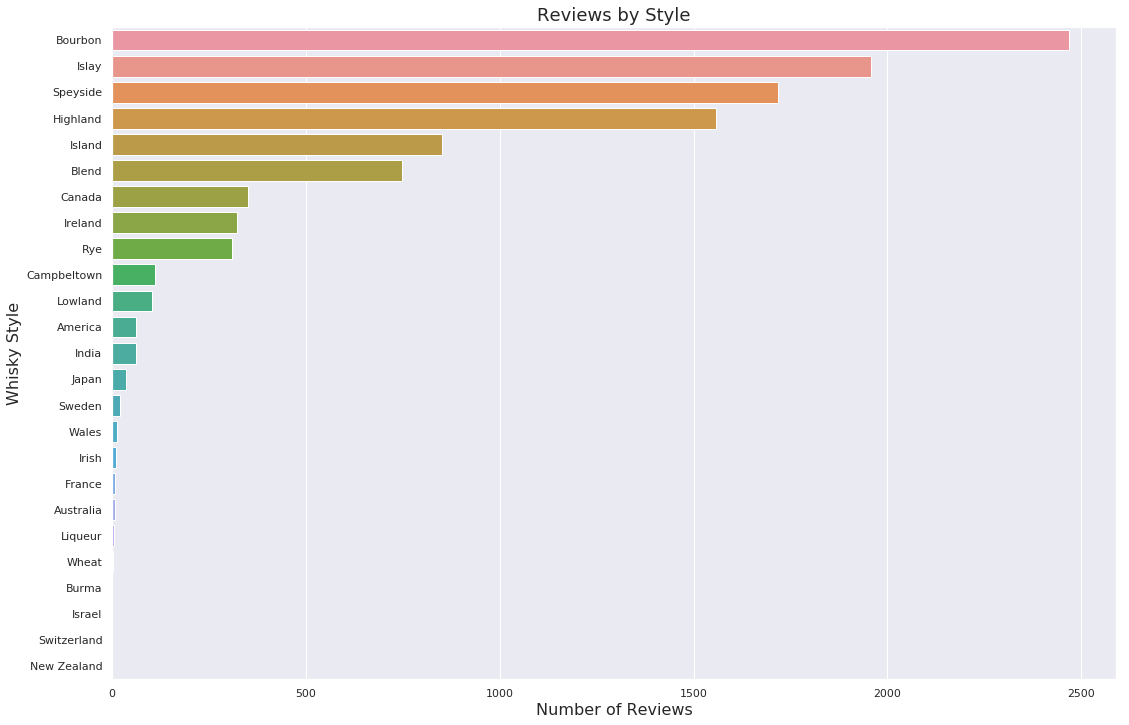

In [375]:
reviewbystyle = (pd.DataFrame(reviews['style'].value_counts())
                     .reset_index()
                     .rename({'style':'reviewCount','index':'style'},axis='columns')
                )
showplot(reviewbystyle, 'bar', 'Reviews by Style', 
         'Number of Reviews', 'Whisky Style', y="style", x='reviewCount', figsize='large')

Bourbon looks to be the most popular but Reddit subdivides Scotch a lot more so if you add up all of the Scotch regions you end up with a lot more Scotch than Bourbon.

## Reviews per User
In order to determine if using users to help with recommendations is viable or not, let's see how many reviews a single user tend to provide:

### Overall

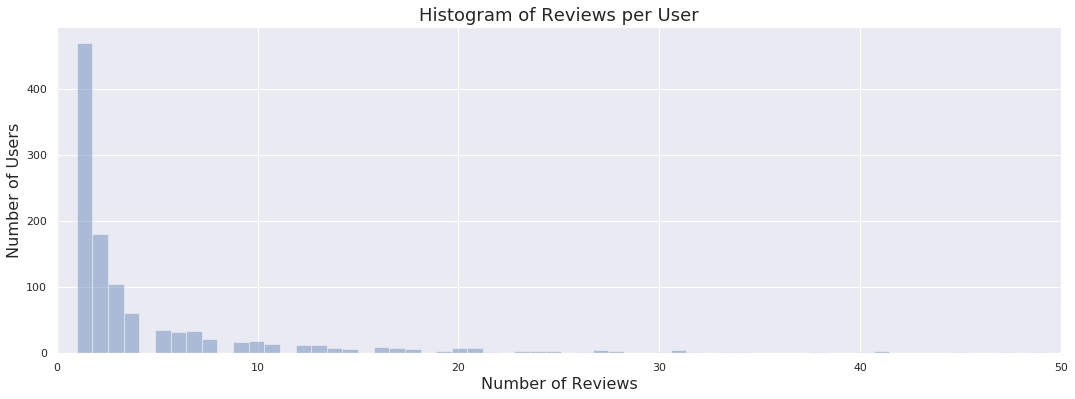

In [370]:
reviewbyuser = reviews.groupby('username')[('reviewID')].count()
showplot(reviewbyuser, 'dist', 'Histogram of Reviews per User', 'Number of Reviews', 'Number of Users', xmax=50, bins=500)

There are a lot of users without many reviews!

For a good recommendation algorithm we will want a lot of reviewers with at least a few reviews.

### Percentage Usable

Which percentage of our users have less than 5 reviews?

In [371]:
reviewbyuser = pd.DataFrame(reviewbyuser).rename({'reviewID':'reviewCount'}, axis='columns')

fewreviews = reviewbyuser[reviewbyuser.reviewCount <= 5].shape[0]
allreviews = reviewbyuser.shape[0]
print(str(fewreviews) + ' / ' + str(allreviews) + ' ('+
      str(round(100*fewreviews/allreviews,0))+'%) users have less than 5 reviews')

851 / 1173 (73.0%) users have less than 5 reviews


Unfortunately most users have very few reviews! This means a user based recommendation system will be very flawed. Due to this I will instead focus of looking at flavour profile similarity.

### Most Active Users
Out of curiousity let's look at the most active users:

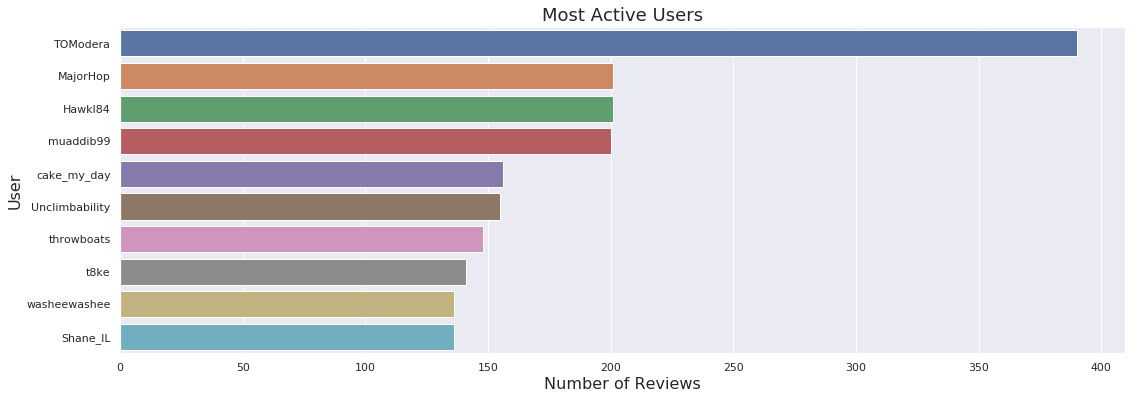

In [372]:
topreviewers = (pd.DataFrame(reviewbyuser)
                   .rename({'reviewID':'reviewCount'}, axis='columns')
                   .sort_values(by='reviewCount',ascending=False)
                   .head(10)
                   .reset_index()
                   .rename({'index':'username'})
              )
showplot(topreviewers, 'bar', 'Most Active Users', 'Number of Reviews', 'User', y="username", x='reviewCount', figsize='wide')

The most active reviewer has almost double the reviews of the second place! Impressive.

## Reviews by Rating

### Overall

/opt/tljh/user/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


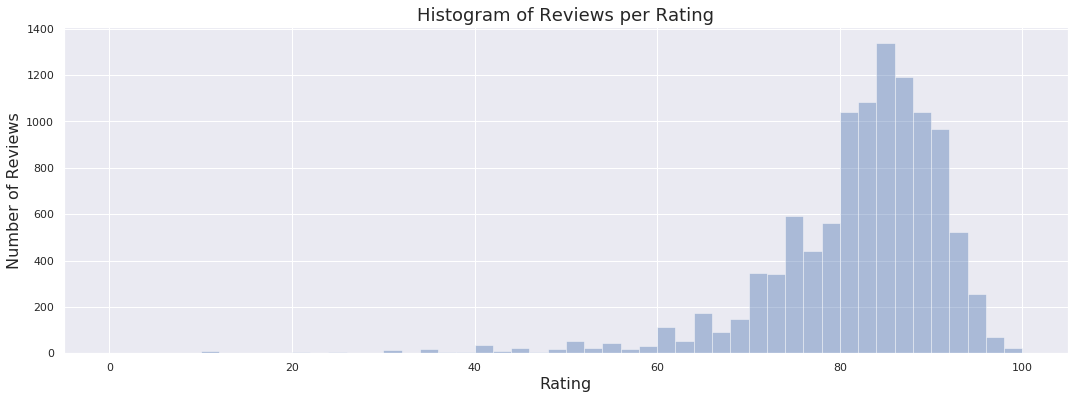

In [373]:
reviewbyrating = reviews['rating']
showplot(reviewbyrating, 'dist', 'Histogram of Reviews per Rating', 'Rating', 'Number of Reviews')

These reviews are heavily leaning towards the right. To use these we will want to normalize them first.

### Top Rated Whiskies
Let's take a look at the highest mean rated whiskies:

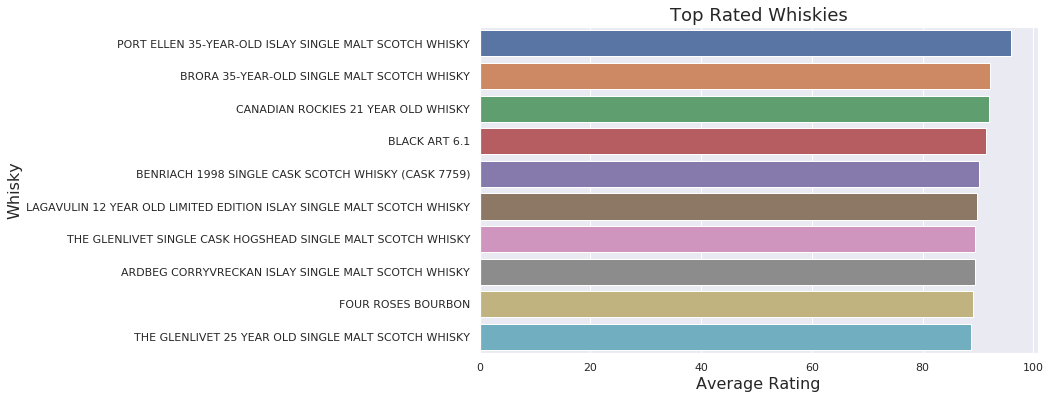

In [374]:
topratedwhiskies = (pd.DataFrame(reviews.groupby('Name')[('rating')].mean())
                    .reset_index()
                    .sort_values(by='rating',ascending=False)
                    .head(10)
                   )
showplot(topratedwhiskies, 'bar', 'Top Rated Whiskies', 
         'Average Rating', 'Whisky', y="Name", x='rating', figsize='small')

Surprising to see some Non Age Statement whiskies on here! I would have expected a lot of the older or rarer ones. Likely people are giving good reviews because of value as well.

## Conclusions

Based on this analysis there are some clear takeaways:

1. Using other users as a basis for recommendations will not be effective. I will instead focus on flavour similarity and overall rating.

2. User ratings are very heavily skewed to the right. I will normalize these values to get a better comparison.